<a href="https://colab.research.google.com/github/Osterne/codes_DS_course/blob/main/05_mod_01_ap_sup_regressao_05_mlg_categoricos_logistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

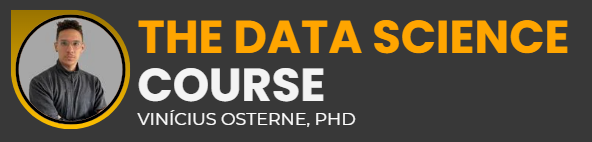

---

# Aprendizado Supervisionado - Modelos Baseados em Regressão

### Modelos Lineares Generalizados - Modelos para Dados Categóricos - Regressão Logística

---
<br><br><br><br><br>

---

## 🚦 Motivação e Contexto

- 🔢 Exemplos de variáveis binárias (0/1):  
  - ✅/❌ Aprovação de crédito  
  - 💉 Doente / Não doente  
  - 🛒 Compra / Não compra  
  - ⚽ Vitória / Derrota  

- ⚠️ Por que não usar Normal (OLS)?  
  - ❌ OLS pode prever probabilidades fora do intervalo [0,1].  
  - ❌ Erros não são homocedásticos.  
  - ❌ A relação entre preditores e resposta não é linear.  

> 💡 **Motivação**: A **Regressão Logística** modela a **probabilidade de sucesso** e garante valores entre 0 e 1.

<br><br><br>

---

## 🧩 Estrutura Geral dos Modelos Lineares Generalizados (MLG) para Logística

Um MLG é definido a partir de **três componentes principais**:

### 🎲 1. Componente Aleatório
- A variável resposta é binária:  
  $$
  Y_i \sim \text{Bernoulli}(\pi_i)
  $$
- Momentos:  
  $$
  \mathbb{E}[Y_i] = \pi_i, \qquad \text{Var}(Y_i) = \pi_i (1 - \pi_i)
  $$

---

### 📊 2. Componente Sistemático
- Representa a **combinação linear dos preditores**:  
  $$
  \eta_i = \mathbf{x}_i^\top \boldsymbol{\beta}
  $$

---

### 🔗 3. Função de Ligação
- Conecta a probabilidade $\pi_i$ ao previsor linear $\eta_i$:  
  $$
  g(\pi_i) = \eta_i
  $$

| Ligação        | Fórmula                          | Observações |
|----------------|----------------------------------|-------------|
| 🔑 **Logit (canônica)** | $g(\pi) = \log \frac{\pi}{1-\pi}$ | Mais usada; interpretação em termos de *odds ratio*. |
| ➡️ **Probit** | $g(\pi) = \Phi^{-1}(\pi)$ | Usa a CDF Normal; útil em bioestatística. |
| ➡️ **Complemento log-log** | $g(\pi) = \log(-\log(1-\pi))$ | Boa para eventos raros. |

---

✅ **Resumo para a Regressão Logística**  
- **Aleatório**: $Y_i \sim \text{Bernoulli}(\pi_i)$  
- **Sistemático**: $\eta_i = \mathbf{x}_i^\top \boldsymbol{\beta}$  
- **Ligação típica**: $\log \left(\frac{\pi}{1-\pi}\right) = \eta_i$  

<br><br><br>

---

## ⚠️ Limitações da Logística

- Não lida com **dependência temporal** ou correlação entre observações (usar modelos mistos ou GEE).  
- Para **desbalanceamento extremo** (ex.: 1% de sucessos), o ajuste pode ser instável.  
- Interpretação em termos de *odds ratio* pode não ser intuitiva para leigos.  

<br><br><br>

---

## 🔍 Comparações e Critérios de Escolha

- **Medidas de ajuste**:  
  - Deviance Residual, Pearson Residual.  
  - Pseudo-$R^2$ (McFadden, Nagelkerke).  
  - AUC (Área sob a curva ROC).  

- **Critérios de informação (AIC, BIC)**:  
  - Usados para comparar diferentes especificações de modelos.  

- **Regras práticas**:  
  - ✔️ **Logística**: para variáveis binárias comuns.  
  - ✔️ **Probit**: quando se assume normalidade latente.  
  - ✔️ **Complemento log-log**: para eventos raros.  

<br><br><br>

---

## 📌 Comentário em relação a outros GLMs
- Diferente de Gama/Normal Inversa (para dados contínuos positivos), a **Logística** é voltada a **respostas binárias**.  
- Todos compartilham a mesma estrutura (Aleatório + Sistemático + Ligação), mas variam pela escolha da distribuição e do link.  

<br><br><br>

---

## 🔍 Aplicação (em Python)

- Pacotes necessários  
- Carregamento dos dados  
- Estatística Descritiva  
- Ajuste do Modelo (GLM Logit)  
- Interpretação dos resultados  
- Diagnóstico do ajuste

### Aplicação

In [29]:
# ----------------------------------------------------
# 1. Pacotes necessários
# ----------------------------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, classification_report,
    precision_recall_curve, brier_score_loss
)
from sklearn.calibration import calibration_curve

plt.rcParams["figure.figsize"] = (6,4)
plt.rcParams["axes.grid"] = True

$$x^2$$

In [30]:
# ----------------------------------------------------
# 2. Carregamento dos dados
# ----------------------------------------------------
# Dataset Titanic do seaborn
titanic = sns.load_dataset("titanic")

# Selecionar variáveis de interesse: sobrevivência ~ idade + sexo + classe
df = titanic[["survived", "age", "sex", "pclass"]].dropna().copy()

# Converter sexo em variável binária
df["sex"] = df["sex"].map({"male": 0, "female": 1})

print("Amostra (5 primeiras linhas):")
print(df.head(), "\n")

Amostra (5 primeiras linhas):
   survived   age  sex  pclass
0         0  22.0    0       3
1         1  38.0    1       1
2         1  26.0    1       3
3         1  35.0    1       1
4         0  35.0    0       3 



# 📌 Variáveis do dataset Titanic (subconjunto usado)

## 🎯 Variável resposta
- **`survived`**
  - Tipo: binária (0/1).
  - 0 = passageiro não sobreviveu.
  - 1 = passageiro sobreviveu.
  - É a variável que a regressão logística está modelando.

## 🔑 Variáveis preditoras
- **`age`**
  - Tipo: contínua (numérica).
  - Idade do passageiro em anos.
  - Mede como a idade influencia a chance de sobreviver.

- **`sex`**
  - Tipo: categórica, convertida para binária.
  - Codificação usada:
    - 0 = homem (`male`)
    - 1 = mulher (`female`)
  - Permite interpretar diferenças de sobrevivência entre homens e mulheres.

- **`pclass`**
  - Tipo: ordinal (1ª, 2ª ou 3ª classe).
  - Representa a classe da cabine (nível socioeconômico):
    - 1 = 1ª classe (alta)
    - 2 = 2ª classe (média)
    - 3 = 3ª classe (baixa)
  - Geralmente, classes mais altas tiveram maior chance de sobrevivência.

---

👉 O modelo logístico está explicando a probabilidade de **sobreviver (`survived`)** a partir da **idade**, do **sexo** e da **classe socioeconômica**.


In [31]:
# ----------------------------------------------------
# 3. Estatística Descritiva
# ----------------------------------------------------
print("Resumo estatístico:")
print(df.describe(include="all"), "\n")

Resumo estatístico:
         survived         age         sex      pclass
count  714.000000  714.000000  714.000000  714.000000
mean     0.406162   29.699118    0.365546    2.236695
std      0.491460   14.526497    0.481921    0.838250
min      0.000000    0.420000    0.000000    1.000000
25%      0.000000   20.125000    0.000000    1.000000
50%      0.000000   28.000000    0.000000    2.000000
75%      1.000000   38.000000    1.000000    3.000000
max      1.000000   80.000000    1.000000    3.000000 



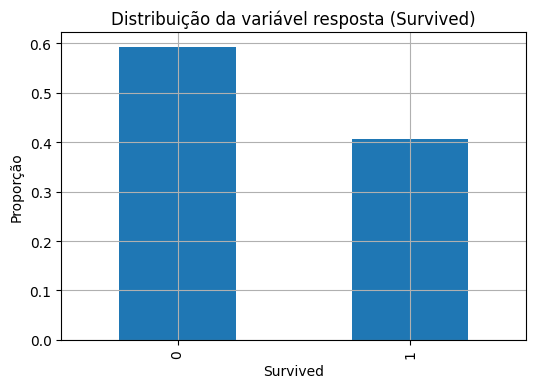

In [32]:
# Distribuição da variável resposta
plt.figure()
df["survived"].value_counts(normalize=True).plot(kind="bar")
plt.title("Distribuição da variável resposta (Survived)")
plt.xlabel("Survived")
plt.ylabel("Proporção")
plt.show()

In [33]:
# ----------------------------------------------------
# 4. Ajuste do Modelo (GLM Logit)
# ----------------------------------------------------
# Fórmula: sobrevivência ~ idade + sexo + classe
modelo_logit = smf.glm(
    formula="survived ~ age + sex + pclass",
    data=df,
    family=sm.families.Binomial(link=sm.families.links.logit())
).fit()

print(modelo_logit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               survived   No. Observations:                  714
Model:                            GLM   Df Residuals:                      710
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -323.65
Date:                Sun, 31 Aug 2025   Deviance:                       647.29
Time:                        19:34:48   Pearson chi2:                     768.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3587
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5339      0.456      5.554      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The logit link alias is deprecated. Use Logit instead. The logit link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [34]:
# ----------------------------------------------------
# 5. Interpretação dos resultados
# ----------------------------------------------------
params = modelo_logit.params
conf = modelo_logit.conf_int()
odds_ratios = np.exp(params)
odds_ci = np.exp(conf)

interpret = pd.DataFrame({
    "coef": params,
    "odds_ratio": odds_ratios,
    "2.5% OR": odds_ci[0],
    "97.5% OR": odds_ci[1]
})
print("\nInterpretação em termos de Odds Ratio:")
print(interpret, "\n")


Interpretação em termos de Odds Ratio:
               coef  odds_ratio   2.5% OR   97.5% OR
Intercept  2.533875   12.602249  5.153351  30.818137
age       -0.036929    0.963745  0.949444   0.978261
sex        2.522131   12.455109  8.296748  18.697654
pclass    -1.288545    0.275672  0.209824   0.362184 



# 📌 Interpretação dos Coeficientes – Regressão Logística (Titanic)

## 🔹 Resultado em Odds Ratio
| Variável   | Coef (β) | Odds Ratio | IC 95% OR             |
|------------|-----------|------------|-----------------------|
| Intercept  | 2.534     | 12.60      | [5.15 ; 30.82]        |
| age        | -0.037    | 0.964      | [0.949 ; 0.978]       |
| sex        | 2.522     | 12.46      | [8.30 ; 18.70]        |
| pclass     | -1.289    | 0.276      | [0.210 ; 0.362]       |

---

## 🔎 Como interpretar

- **Intercepto (OR ≈ 12.6)**  
  - Representa as *odds* de sobrevivência para um passageiro de referência:  
    homem (`sex=0`), idade = 0, e `pclass=0` (apenas referência matemática).  
  - O valor isolado do intercepto **não tem interpretação prática direta**.

- **Idade (OR ≈ 0.964, IC95% [0.949 ; 0.978])**  
  - A cada aumento de **1 ano de idade**, as *odds* de sobrevivência **diminuem cerca de 3,6%**.  
  - (Como OR < 1, a relação é **negativa**).  
  - Passageiros mais velhos tinham menor chance de sobreviver.

- **Sexo (OR ≈ 12.46, IC95% [8.30 ; 18.70])**  
  - Mulheres (`sex=1`) tinham *odds* de sobrevivência cerca de **12 vezes maiores** do que homens.  
  - Forte efeito positivo, altamente significativo.  
  - Confirma a regra histórica: *"women and children first"*.

- **Classe (OR ≈ 0.276, IC95% [0.210 ; 0.362])**  
  - Cada aumento na classe (ex.: de 1ª para 2ª, ou de 2ª para 3ª) **reduz as odds de sobrevivência em cerca de 72%**.  
  - Passageiros de classes mais baixas tinham probabilidade muito menor de sobreviver.  

---

## ✅ Resumo
- **Idade ↑ → chances de sobreviver ↓**.  
- **Mulheres → ~12x mais chances de sobreviver que homens**.  
- **Classe mais baixa → probabilidade de sobreviver muito menor**.  
- O modelo captura bem os padrões históricos do Titanic: **mulheres jovens e de classes altas tinham maior probabilidade de sobrevivência**.


In [35]:
# ----------------------------------------------------
# 6. Diagnóstico do ajuste
# ----------------------------------------------------

In [36]:
# Pseudo R² de McFadden
ll_null = modelo_logit.null_deviance / -2
ll_model = modelo_logit.deviance / -2
pseudo_r2 = 1 - (ll_model / ll_null)
print(f"Pseudo R² (McFadden) = {pseudo_r2:.3f}")

Pseudo R² (McFadden) = 0.329


# 📌 Interpretação do Pseudo R² de McFadden

- **O que é:**  
  - Medida de qualidade do ajuste em modelos de regressão logística (e GLMs binários).  
  - Calculada a partir da log-verossimilhança do modelo ajustado vs modelo nulo (sem preditores).  

- **Escala típica:**  
  - Valores próximos de **0** → modelo não explica nada além do acaso.  
  - Valores entre **0.2 e 0.4** → considerados **muito bons** em regressão logística.  
  - Valores > 0.4 são raros (quase ajuste perfeito).  

- **No seu caso (0.329):**  
  - O modelo explica uma parcela **substancial da variabilidade** na sobrevivência do Titanic.  
  - Está dentro da faixa considerada **excelente ajuste** para dados binários reais.  

---

## ✅ Resumo
Um **Pseudo R² de McFadden = 0.329** indica que o modelo tem **bom poder explicativo**, capturando bem os padrões de sobrevivência a partir de idade, sexo e classe.


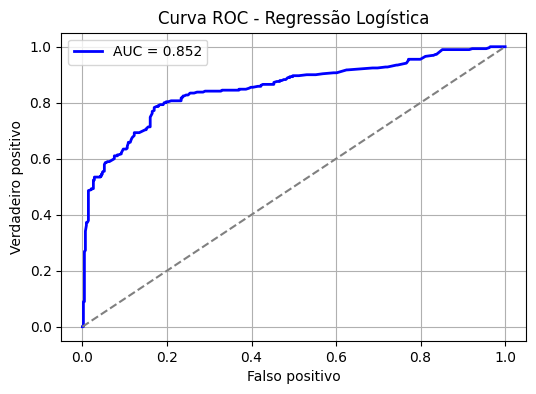

AUC = 0.852


In [37]:
# ROC Curve e AUC
from sklearn.metrics import roc_curve, auc

y_true = df["survived"]
y_score = modelo_logit.predict(df)

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], color="gray", linestyle="--")
plt.xlabel("Falso positivo")
plt.ylabel("Verdadeiro positivo")
plt.title("Curva ROC - Regressão Logística")
plt.legend()
plt.show()

print(f"AUC = {roc_auc:.3f}")

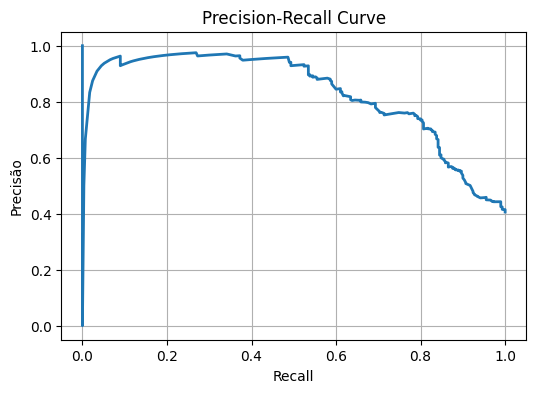

In [38]:
# Precision-Recall
prec, rec, thr_pr = precision_recall_curve(y_true, y_score)
plt.figure()
plt.plot(rec, prec, lw=2)
plt.xlabel("Recall")
plt.ylabel("Precisão")
plt.title("Precision-Recall Curve")
plt.show()